In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise
from decode_fish.engine.model import UnetDecodeNoBn
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [10]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_19/norm:escortxz_facs:Truexmean_diff:Truexlr:0.0005//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_4_os/sl_true_gen//train.yaml')

# cfg.run_name = 'test'

cfg.output.log_interval = 100
cfg.training.bs = 100
cfg.genm.microscope.norm='none'

cfg.training.mic.psf_loss_mult = False
cfg.training.net.enabled = False

cfg.genm.foci.n_foci_avg = 0

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf2n.tif'

# cfg.training.mic.par_grads.channel_facs = False
# cfg.training.mic.par_grads.channel_shifts = False
# cfg.training.mic.par_grads.theta_par = False
# cfg.training.mic.par_grads.psf_vol = True

In [11]:
cfg.training.num_iters = 100000
cfg.training.schedule = None
cfg.training.mic.enabled = True

In [12]:
codebook, targets = get_mop_codebook()

In [13]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)
_=model.cuda()

RuntimeError: Error(s) in loading state_dict for Microscope:
	size mismatch for z_facs: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([11]).
	size mismatch for psf_vol: copying a param with shape torch.Size([2, 7, 21, 21]) from checkpoint, the shape in current model is torch.Size([2, 11, 21, 21]).
	size mismatch for psf.psf_volume: copying a param with shape torch.Size([2, 7, 21, 21]) from checkpoint, the shape in current model is torch.Size([2, 11, 21, 21]).
	size mismatch for psf.z: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([11]).

In [13]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


In [14]:
# inp_offset, inp_scale = get_forward_scaling(img_3d[0])
# # inp_scale = 300
# # inp_offset = 100
# model = hydra.utils.instantiate(cfg.network, inp_scale=inp_scale, inp_offset=inp_offset)

# psf  .to('cuda')
# model.to('cuda')
# micro.to('cuda')

In [15]:
params = []
for param in model.parameters():
    params.append(param)

In [42]:
optim_dict = {}
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters())
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])

In [43]:
# _ = wandb.init(project=cfg.output.project, 
#                config=OmegaConf.to_container(cfg, resolve=True),
#                dir=cfg.output.log_dir,
#                group=cfg.output.group,
#                name=cfg.run_name,
#                mode='online'
#           )

In [44]:
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)

(tensor(3.1337, device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>), tensor(10., device='cuda:0', grad_fn=<DivBackward0>))


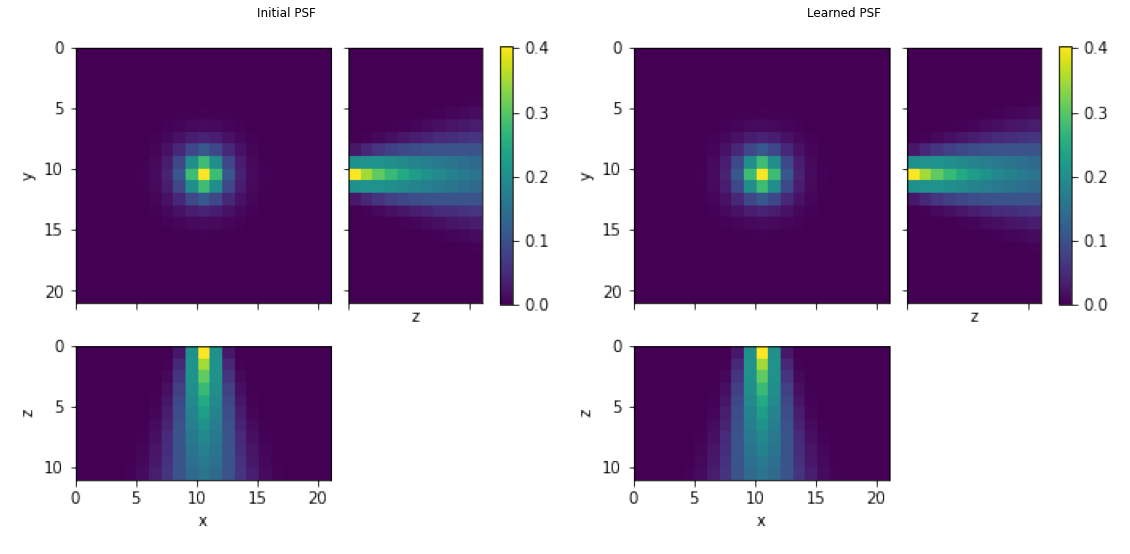

In [45]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

In [46]:
ret_dict = next(iter(decode_dl))
x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']

background = background * micro.get_ch_mult().detach()
x = x * micro.get_ch_mult().detach()

In [47]:
psf, noise, micro = load_psf_noise_micro(cfg)

In [48]:
# micro.load_state_dict(torch.load(cfg.output.save_dir+'/microscope.pkl'), strict=False)

In [49]:
from decode_fish.engine.microscope import concat_micro_inp
# colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)

with torch.no_grad():

    out_col = []
    bg_pred = []
    for i in range(len(x)):
#         out_inp = model.tensor_to_dict(model(torch.concat([x[i:i+1], colshift_crop[i:i+1]], 1)))
        out_inp = model.tensor_to_dict(model(x[i:i+1]))
        out_col.append(post_proc.get_micro_inp(out_inp))
        bg_pred.append(out_inp['background'])

    bg_pred = torch.concat(bg_pred)
    proc_out_inp = concat_micro_inp(out_col, batch_size=1)
    
    ch_out_inp = micro.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
    filt_inds = get_roi_filt_inds(*ch_out_inp[0], micro.psf.psf_volume.shape, x.shape, slice_rec=cfg.genm.exp_type.slice_rec, min_dist=10)
    print(len(ch_out_inp[1]), len(filt_inds))
    ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)
    
    rois = extract_psf_roi(ch_out_inp[0], x, torch.tensor([len(ch_out_inp[1]), 1,1,21,21]))
    bgs = extract_psf_roi(ch_out_inp[0], bg_pred, torch.tensor([len(ch_out_inp[1]), 1,1,21,21]))

    psf_recs = micro(*ch_out_inp, ret_psfs=True, add_noise=False)
    
    mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)
    
    ch_inds = ch_out_inp[0][1]
    int_vals = ch_out_inp[-2]

21892 2837


In [30]:
torch.sqrt(((rois-gpu(mean_diff)-(psf_recs+bgs))**2).mean())

tensor(257.4594, device='cuda:0')

In [31]:
torch.sqrt(((rois-(psf_recs+bgs))**2).mean())

tensor(287.3651, device='cuda:0')

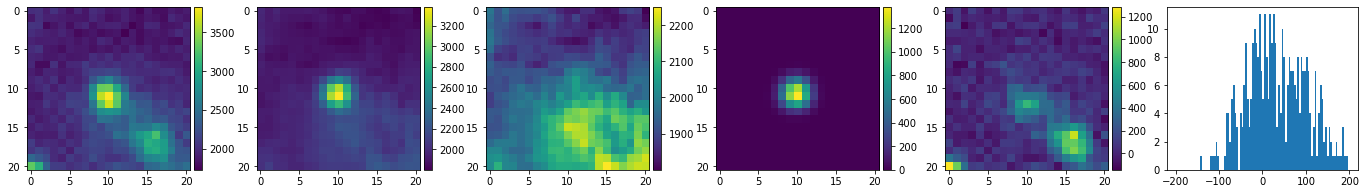

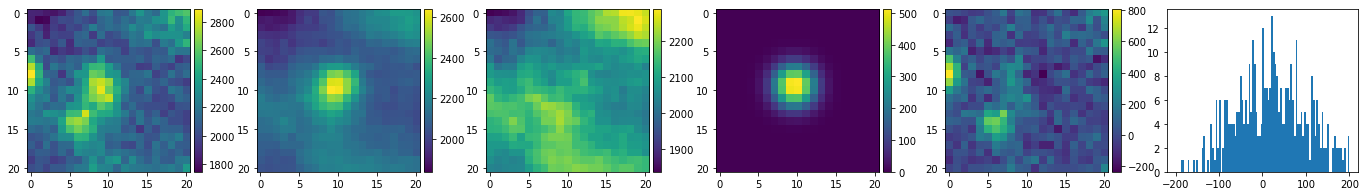

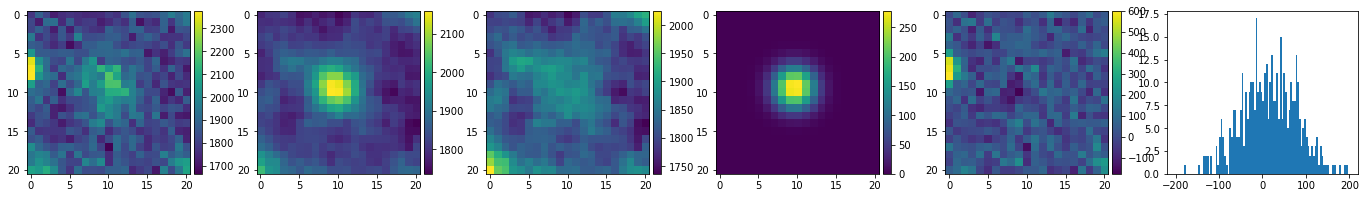

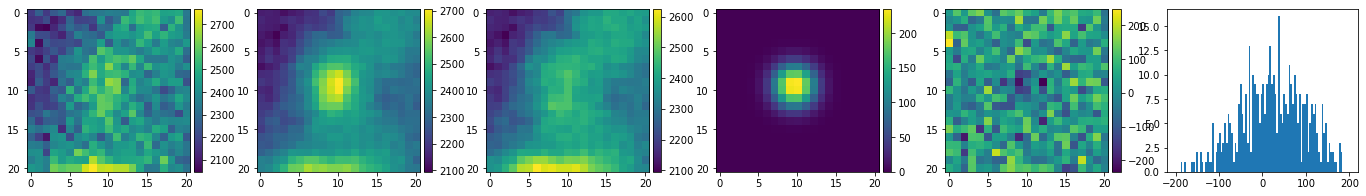

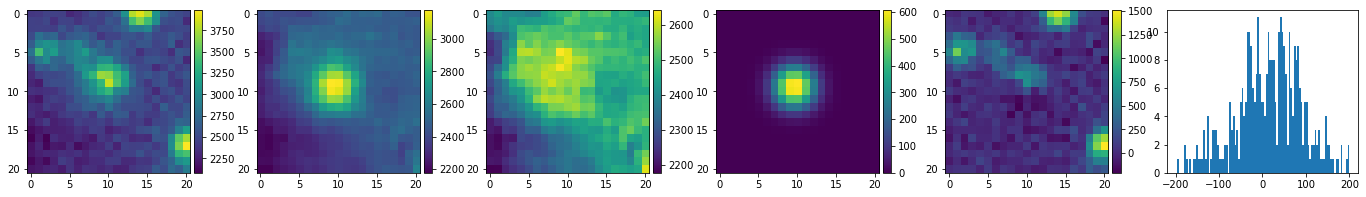

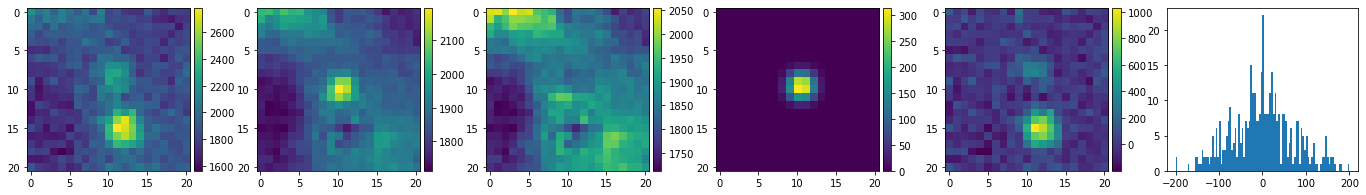

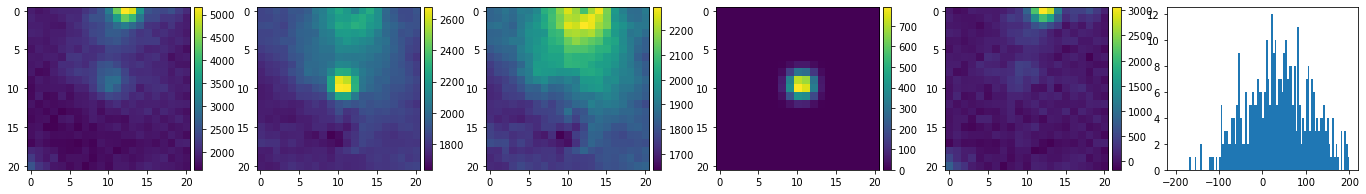

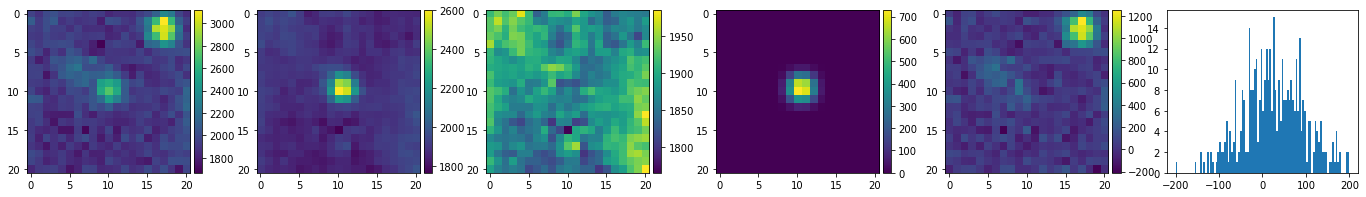

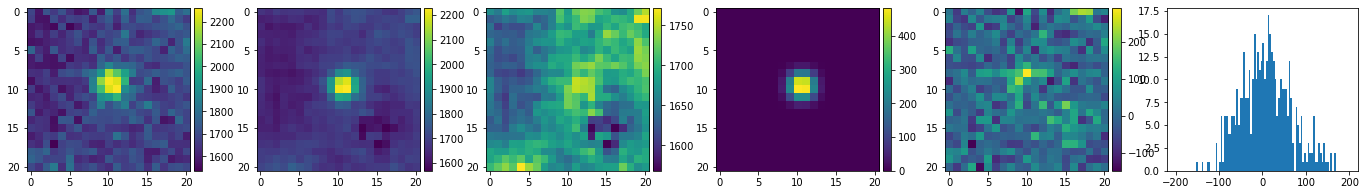

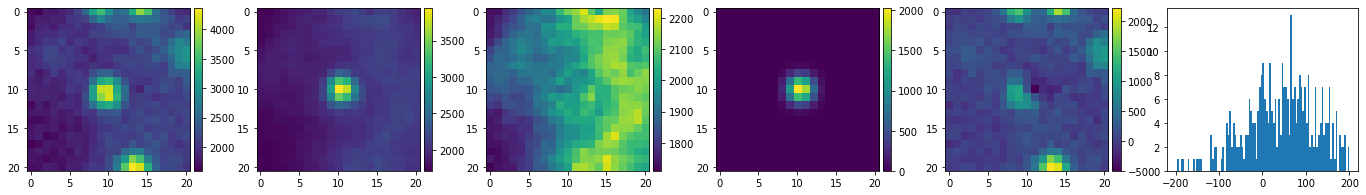

In [34]:
for i in range(10):
    plt.figure(figsize=(24,3))
    plt.subplot(161)
    im = plt.imshow(cpu(rois)[i,0,0])
    add_colorbar(im)
    plt.subplot(162)
    im = plt.imshow(cpu(psf_recs+bgs)[i,0,0])
    add_colorbar(im)
    plt.subplot(163)
    im = plt.imshow(cpu(bgs)[i,0,0])
    add_colorbar(im)
    plt.subplot(164)
    im = plt.imshow(cpu(psf_recs)[i,0,0])
    add_colorbar(im)
    plt.subplot(165)
    im = plt.imshow(cpu(rois - psf_recs - bgs)[i,0,0])
    add_colorbar(im)
    plt.subplot(166)
    plt.hist(cpu(rois - psf_recs - bgs)[i,0,0].reshape(-1), bins=np.linspace(-200,200,101))
    plt.show()

In [32]:
# Resume training from a previous checkpoint
if cfg.data_path.micro_init is not None:
    micro.load_state_dict(torch.load(cfg.data_path.micro_init), strict=False)
    
# cfg.data_path.model_init = cfg.output.save_dir
# cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_5b/int_loc:0.1xscale:400xpsf_noise:0.0'

if cfg.data_path.model_init is not None:
    print('loading')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()
#     micro.load_state_dict(torch.load(Path(cfg.data_path.model_init)/'microscope.pkl'), strict=False)

loading


In [50]:
save_dir = Path(cfg.output.save_dir)

model.cuda().train()

# Save initial psf state

# Load codebook 
if 'codebook' in cfg:
    code_ref, targets = hydra.utils.instantiate(cfg.codebook)
#         bench_df = exclude_borders(bench_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

# Controls which genmodel parameters are optimized
for name, p in micro.named_parameters():
    p.requires_grad = cfg.training.mic.par_grads[name]


for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters+1):
    
    optim_dict['optim_mic'].zero_grad()
    calc_log_p_x = False

    ch_out_inp = micro.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
    ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)

    psf_recs = micro(*ch_out_inp, ret_psfs=True, add_noise=False)  

    log_p_x_given_z = -micro.noise(psf_recs, bgs, const_theta_sim=False, ch_inds=ch_out_inp[0][1]).log_prob(rois.clamp_min_(1.))

    log_p_x_given_z = log_p_x_given_z.mean()
#     print(log_p_x_given_z)

    if cfg.training.mic.norm_reg:
        log_p_x_given_z += cfg.training.mic.norm_reg * (micro.psf.com_loss())

    log_p_x_given_z.backward()
    if cfg.training.mic.grad_clip:
        torch.nn.utils.clip_grad_norm_(micro.parameters(), max_norm=cfg.training.mic.grad_clip, norm_type=2)

    optim_dict['optim_mic'].step()
    optim_dict['sched_mic'].step()
    
    print(log_p_x_given_z.detach().cpu())

#                 print('PSF ', time.time()-t0); t0 = time.time()
    # Logging
#     if batch_idx % 10 == 0:
#         print(log_p_x_given_z)
#         wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
#         wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((rois-(psf_recs+bgs))**2).mean()).detach().cpu()}, step=batch_idx)
#         wandb.log({'AE Losses/sum(psf)': F.relu(micro.psf.psf_volume)[0].sum().detach().cpu()}, step=batch_idx)

wandb.finish()

tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(11.6206)
tensor(1

KeyboardInterrupt: 

In [46]:
model.cuda()

UnetDecodeNoBn(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (conv): Conv3d(24, 192, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
          (SingleConv2): SingleConv(
            (conv): Conv3d(192, 384, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=[1, 2, 2], stride=[1, 2, 2], padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (conv): Conv3d(384, 384, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
          (SingleConv2): SingleConv(
        

In [59]:
_=model.cuda()

In [ ]:
cfg.output

In [ ]:
# hydra.utils.call(cfg.evaluation.code_stats.eval_func, model=model, post_proc=post_proc, targets=targets, cfg=3, wandb=2, batch_idx=1)
# hydra.utils.call(cfg.evaluation.code_stats.eval_func, model=1, post_proc=2, targets=3, cfg=cfg, wandb=5, batch_idx=6)

In [ ]:
!nbdev_build_lib

In [66]:
ch_out_inpdddd

([tensor([1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
          4, 4, 4, 6, 6, 6, 6, 8, 8, 8, 8, 9, 9, 9, 9], device='cuda:0'),
  tensor([ 8, 15, 17,  5, 15, 16,  4, 14, 20,  0,  5, 11, 18,  7, 11, 15, 20,  0,
           3,  7, 14,  0,  4, 20,  3,  6, 15,  3,  6, 14, 15,  0,  2, 14, 21,  7,
          11, 12, 14], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([32, 32, 32, 26, 26, 26, 35, 35, 35, 29, 29, 29, 29, 16, 16, 16, 16, 15,
          15, 15, 15, 42, 42, 42, 43, 43, 43, 38, 38, 38, 38, 21, 21, 21, 21, 17,
          17, 17, 17], device='cuda:0'),
  tensor([39, 39, 39, 43, 43, 43, 40, 40, 40, 16, 16, 16, 16, 45, 45, 45, 45, 22,
          22, 22, 22, 33, 33, 33, 34, 34, 34, 21, 21, 21, 21, 40, 40, 40, 40, 44,
          44, 44, 44], device='cuda:0')],
 tensor([ 0.2150,  0.3068,  0.2061,  0.3310,  0.1369,  0.1469, -0.3103, 

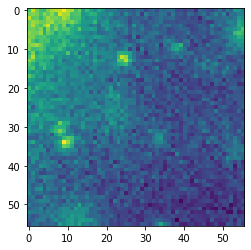

In [39]:
plt.imshow(cpu(x[455,0,0]))

In [34]:
microscope.get_ch_mult().detach()

tensor([[[[[0.1216]]],


         [[[0.3949]]],


         [[[0.4625]]],


         [[[0.1481]]],


         [[[0.2026]]],


         [[[0.5073]]],


         [[[0.1887]]],


         [[[0.6449]]],


         [[[0.6170]]],


         [[[0.2700]]],


         [[[0.2219]]],


         [[[0.6842]]],


         [[[0.2019]]],


         [[[0.7756]]],


         [[[0.6881]]],


         [[[0.2152]]],


         [[[0.2558]]],


         [[[0.8090]]],


         [[[0.2731]]],


         [[[0.8289]]],


         [[[0.9308]]],


         [[[0.2761]]]]], device='cuda:0')

In [33]:
len(ch_out_inp[1])

153452

In [20]:
microscope(*ch_out_inp, ret_psfs=True, add_noise=False).shape

torch.Size([1000, 22, 1, 56, 56])

In [26]:
microscope(*ch_out_inp, ret_psfs=True, add_noise=False)

torch.Size([1000, 22, 1, 56, 56])

In [27]:
model.cuda()dd

UnetDecodeNoBn(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (conv): Conv3d(24, 192, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
          (SingleConv2): SingleConv(
            (conv): Conv3d(192, 384, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=[1, 2, 2], stride=[1, 2, 2], padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (conv): Conv3d(384, 384, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), padding_mode=replicate)
            (ELU): ELU(alpha=1.0, inplace=True)
          )
          (SingleConv2): SingleConv(
        

In [21]:
ch_out_inp[0]

[tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0', dtype=torch.int64)]

In [20]:
from decode_fish.engine.microscope import concat_micro_inp

In [116]:
torch.sqrt(((rois-(psf_recs+bgs))**2).mean())

tensor(146.8952, device='cuda:0')

In [ ]:
torch.sqrt(((rois-edge_diff[:,None,None,None,None]-(psf_recs+bgs))**2).mean())

In [107]:
torch.sqrt(((rois-gpu(edge_diff)[:,None,None,None,None]-(psf_recs+bgs))**2).mean())

tensor(123.5626, device='cuda:0')

In [125]:
mean_diff.shape

torch.Size([14906, 1, 1, 1, 1])

In [119]:
mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)

NameError: name 'cpu9mean_diff' is not defined

In [117]:
edge_diff = cpu(rois).mean(-1).mean(-1).mean(-1).mean(-1) - cpu(psf_recs+bgs).mean(-1).mean(-1).mean(-1).mean(-1)

In [103]:
for k in range(1,12):
    bg_edges = torch.cat([bgs[:,0,0,:k,:].flatten(1,2), bgs[:,0,0,-k:,:].flatten(1,2), bgs[:,0,0,:,:k].flatten(1,2), bgs[:,0,0,:,-k:].flatten(1,2)], 1)
    rois_edges = torch.cat([rois[:,0,0,:k,:].flatten(1,2), rois[:,0,0,-k:,:].flatten(1,2), rois[:,0,0,:,:k].flatten(1,2), rois[:,0,0,:,-k:].flatten(1,2)], 1)
    edge_diff = rois_edges.mean(-1) - bg_edges.mean(-1)
    print(k, torch.sqrt(((rois-edge_diff[:,None,None,None,None]-(psf_recs+bgs))**2).mean()))

1 tensor(127.9380, device='cuda:0')
2 tensor(127.2574, device='cuda:0')
3 tensor(126.6592, device='cuda:0')
4 tensor(126.1062, device='cuda:0')
5 tensor(125.5664, device='cuda:0')
6 tensor(125.0620, device='cuda:0')
7 tensor(124.5807, device='cuda:0')
8 tensor(124.1349, device='cuda:0')
9 tensor(123.9442, device='cuda:0')
10 tensor(124.6004, device='cuda:0')
11 tensor(126.2729, device='cuda:0')


In [76]:
bg_edges = torch.cat([bgs[:,0,0,:5,:].flatten(1,2), bgs[:,0,0,-5:,:].flatten(1,2), bgs[:,0,0,:,:5].flatten(1,2), bgs[:,0,0,:,-5:].flatten(1,2)], 1)
rois_edges = torch.cat([rois[:,0,0,:5,:].flatten(1,2), rois[:,0,0,-5:,:].flatten(1,2), rois[:,0,0,:,:5].flatten(1,2), rois[:,0,0,:,-5:].flatten(1,2)], 1)

In [45]:
bg_edges = torch.cat([bgs[:,0,0,0,:], bgs[:,0,0,-1,:], bgs[:,0,0,:,0], bgs[:,0,0,:,-1]], 1)
rois_edges = torch.cat([rois[:,0,0,0,:], rois[:,0,0,-1,:], rois[:,0,0,:,0], rois[:,0,0,:,-1]], 1)